# Imports

In [2]:
import logging
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR) # suppress warnings

# Dataset

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

2022-04-07 15:21:51.589620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 15:21:51.707669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 15:21:51.707922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 15:21:51.709226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Yields pairs of text examples

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2022-04-07 15:21:58.782633: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Tokenizer

In [6]:
os.environ['HTTP_PROXY']='http://127.0.0.1:1080'
os.environ['HTTPS_PROXY']='http://127.0.0.1:1080'
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

In [10]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The "tokenize" method converts a batch of strings to a padded-batch pf token IDs. This method splits punctuation, lowercases and unicodenormalizes the input before tokenizing

In [11]:
for en in en_examples.numpy():
    print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [12]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


# Detokenize

In [13]:
round_trip = tokenizers.en.detokenize(encoded)

for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level lookup method converts from token-IDs to token text
Here you can see the subword aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serendipity" into "s ##ere ##nd ##ip ##ity"

In [14]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

Investigate the distribution of tokens per example in the dataset

In [43]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

Text(0.5, 1.0, 'Max tokens per example: 320')

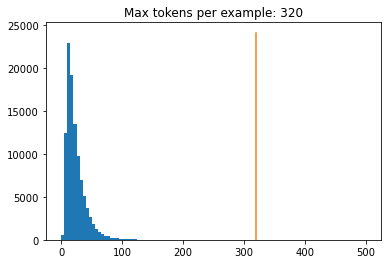

In [48]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}')

In [49]:
MAX_TOKENS = 128

Drop the examples longer than MAX_TOKENS

In [50]:
def filter_max_tokens(pt, en):
    num_tokens = tf.maximum(tf.shape(pt)[1], tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

tokenize the batches of raw text

In [51]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # convert from ragged to dense, padding with zero
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # convert from ragged to dense, padding with zero
    en = en.to_tensor()

    return pt, en

a simple input pipeline that processes, shuffles and batches the data

In [52]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [53]:
def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .filter(filter_max_tokens)
        .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

# Positional encoding

# HERE

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2) / np.float32(d_model)))
    return pos * angle_rates

In [58]:
i = 5
(i//2)

2

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

In [62]:
np.arange(5)[:, np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [63]:
np.arange(5)[np.newaxis, :]

array([[0, 1, 2, 3, 4]])

In [61]:
print(np.newaxis)

None


In [79]:
a = np.array([[0, 4], [0, 4]])
b = np.sin(a[:, 1::2])

In [80]:
b

array([[-0.7568025],
       [-0.7568025]])

In [81]:
c = "sdfsafg"
print(c[0::2])

sfag
